 # 化合物寿命延长效应预测回归模型

**任务**: 预测化合物对线虫寿命的具体延长效果 (0, 1)。

**模型**: 基于AttentiveFP处理分子图，CNN处理MACCS指纹，DNN处理Morgan和拓扑指纹，最后融合预测。

**运行环境**: Python 3.9.22 + DeepChem + DGL

#
**重要前提**:

# 1. 数据预处理:
    - 使用`featurizer.py`的脚本处理`train.csv`和`test.csv`，生成图特征 (`adj.npy`, `feature.npy`) 和数值标签 (`label.npy`，直接使用Life_extended列的值)。
    - 使用`fingerprint.py`脚本生成Morgan、拓扑指纹 (`...hash.csv`) 和MACCS指纹 (`...nonhash.csv`)。
    - 所有预处理文件应按`CONFIG`中指定的路径存放。

In [1]:
import sys
import torch

print("Python version:", sys.version)
print("PyTorch version:", torch.__version__)
print("Is CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("CUDA version:", torch.version.cuda)
    print("GPU name:", torch.cuda.get_device_name(0))

try:
    import deepchem
    print("DeepChem version:", deepchem.__version__)
except ImportError:
    print("DeepChem is not installed.")

# DGL and DGL-LifeSci
try:
    import dgl
    from dgl import batch as dgl_batch
    print("DGL version:", dgl.__version__)
except ImportError:
    print("DGL is not installed.")

try:
    from dgllife.model.gnn import AttentiveFPGNN
    from dgllife.model.readout import AttentiveFPReadout
    import dgllife
    print("DGL-LifeSci (dgllife) version:", dgllife.__version__)
except ImportError:
    print("DGL-LifeSci is not installed.")


Python version: 3.9.22 | packaged by conda-forge | (main, Apr 14 2025, 23:26:18) [MSC v.1929 64 bit (AMD64)]
PyTorch version: 2.1.0+cu118
Is CUDA available: True
CUDA version: 11.8
GPU name: NVIDIA GeForce RTX 3050 Laptop GPU


No normalization for SPS. Feature removed!
No normalization for AvgIpc. Feature removed!
No normalization for NumAmideBonds. Feature removed!
No normalization for NumAtomStereoCenters. Feature removed!
No normalization for NumBridgeheadAtoms. Feature removed!
No normalization for NumHeterocycles. Feature removed!
No normalization for NumSpiroAtoms. Feature removed!
No normalization for NumUnspecifiedAtomStereoCenters. Feature removed!
No normalization for Phi. Feature removed!


Instructions for updating:
experimental_relax_shapes is deprecated, use reduce_retracing instead


c:\ProgramData\anaconda3\envs\deepchem\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Skipped loading modules with transformers dependency. No module named 'transformers'
cannot import name 'HuggingFaceModel' from 'deepchem.models.torch_models' (c:\ProgramData\anaconda3\envs\deepchem\lib\site-packages\deepchem\models\torch_models\__init__.py)
Skipped loading modules with pytorch-lightning dependency, missing a dependency. No module named 'lightning'
Skipped loading some Jax models, missing a dependency. No module named 'jax'


DeepChem version: 2.8.0
DGL version: 2.2.1+cu118
DGL-LifeSci (dgllife) version: 0.3.2


In [ ]:
# CONFIG definition

import torch
import os

PROJECT_BASE_DIR = r"D:\FJTCM\DeepLife\DLProject" # Define this once

CONFIG = {
    "target_name_train": "LifespanReg_train",
    "target_name_test": "LifespanReg_test",
    "train_csv_path": os.path.join(PROJECT_BASE_DIR, "train.csv"),
    "test_csv_path": os.path.join(PROJECT_BASE_DIR, "test.csv"),

    # Path to pre-processed graph features (from run_featurizer_lifespan.py)
    "graph_feature_base_path": os.path.join(PROJECT_BASE_DIR, "processed_graph_features"),
    # Path to pre-processed fingerprints (from run_fingerprint_lifespan_simplified.py)
    "fingerprint_base_path": os.path.join(PROJECT_BASE_DIR, "processed_fingerprints"),

    "results_dir": os.path.join(PROJECT_BASE_DIR, "lifespan_regression_results_notebook"),

    "device": "cuda" if torch.cuda.is_available() else "cpu",
    "seed": 42,

    # Featurizer.py related (MUST MATCH run_featurizer_lifespan.py settings)
    "max_atoms_featurizer": 200,
    "atom_feature_dim_featurizer": 75,

    # Fingerprint.py related (MUST MATCH run_fingerprint_lifespan_simplified.py settings)
    "morgan_nbits": 2048,
    "rdkit_fp_nbits": 2048,
    "maccs_nbits": 166,
    # "fingfeaf_dim" will be morgan_nbits + rdkit_fp_nbits
    # "fingfeac_dim" will be maccs_nbits

    # Model architecture
    "enable_graph_gnn": True,
    "enable_fp_hashed_dnn": True,
    "enable_fp_nonhash_cnn": True,
    "gnn_node_input_dim": 78, # From ConvMolFeaturizer used in GraphDataForDGL
    "gnn_edge_input_dim": 11, # From MolGraphConvFeaturizer used in GraphDataForDGL
    "gnn_graph_embed_dim": 128,
    "gnn_num_layers": 2,
    "gnn_num_timesteps": 2,
    "gnn_dropout": 0.5,
    "fp_nonhash_cnn_output_dim": 64,
    "fp_hashed_dnn_layers": [256,128], # Simplified DNN for FPs
    "fp_hashed_dnn_output_dim": 64,   # Reduced output dim for FPs
    "fp_dropout": 0.5,

    # Training
    "n_output_tasks": 1,
    "max_epochs": 100, # Start with fewer for testing
    "batch_size": 32,
    "learning_rate": 0.0001,
    "weight_decay": 1e-4,
    "patience": 15,
    "print_every_n_epochs": 5,
    "main_metric_name": "MAE", # 'RMSE' or 'MAE' for regression (lower is better)
}

# --- Derived CONFIG ---
CONFIG["fingfeaf_dim"] = CONFIG["morgan_nbits"] + CONFIG["rdkit_fp_nbits"]
CONFIG["fingfeac_dim"] = CONFIG["maccs_nbits"]

# --- Create results_dir for Notebook ---
os.makedirs(CONFIG["results_dir"], exist_ok=True)

print(f"Project Base Directory: {PROJECT_BASE_DIR}")
print(f"Graph Features Path: {CONFIG['graph_feature_base_path']}")
print(f"Fingerprints Path: {CONFIG['fingerprint_base_path']}")
print(f"Notebook Results Path: {CONFIG['results_dir']}")
print(f"Using device: {CONFIG['device']}")
print(f"Results will be saved to: {CONFIG['results_dir']}")
print(f"Hashed FP dimension (DNN input): {CONFIG['fingfeaf_dim']}")
print(f"Non-hashed FP dimension (CNN input): {CONFIG['fingfeac_dim']}")

Project Base Directory: D:\FJTCM\DeepLife\DLProject
Graph Features Path: D:\FJTCM\DeepLife\DLProject\processed_graph_features
Fingerprints Path: D:\FJTCM\DeepLife\DLProject\processed_fingerprints
Notebook Results Path: D:\FJTCM\DeepLife\DLProject\lifespan_regression_results_notebook
Using device: cuda
Results will be saved to: D:\FJTCM\DeepLife\DLProject\lifespan_regression_results_notebook
Hashed FP dimension (DNN input): 4096
Non-hashed FP dimension (CNN input): 166


## 2. 导入所需库

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import pandas as pd
from tqdm import tqdm
import shutil

import torch
from torch import nn
import torch.nn.functional as F
from torch_geometric.data import Data, InMemoryDataset, DataLoader as PyGDataLoader
from dgl import batch as dgl_batch
from dgllife.model.gnn import AttentiveFPGNN
from dgllife.model.readout import AttentiveFPReadout

# RDKit and DeepChem (only for on-the-fly featurization if needed, primarily for graph construction in dataset.py style)
from rdkit import Chem
import deepchem as dc # For MolGraphConvFeaturizer if generating edge_features on the fly for DGL

# Metrics from torchmetrics (for regression)
from torchmetrics.functional.regression import pearson_corrcoef

# 设置随机种子
import random
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
set_seed(CONFIG["seed"])

# Matplotlib/Seaborn 全局样式
sns.set_theme(style="whitegrid", context="notebook", font_scale=1.1) # "notebook" context is good for jupyter
plt.rcParams['figure.figsize'] = (8, 6)
plt.rcParams['figure.dpi'] = 300


## 3. 定义模型评估指标 (回归)

In [44]:
from abc import ABC

class BaseMetric(ABC): # Renamed to BaseMetric
    def __init__(self):
        super().__init__()
        self.name = None

    def __call__(self, y_true, y_pred):
        if isinstance(y_true, torch.Tensor): y_true = y_true.cpu().numpy()
        if isinstance(y_pred, torch.Tensor): y_pred = y_pred.cpu().numpy()
        y_true = np.squeeze(y_true) # Ensure 1D
        y_pred = np.squeeze(y_pred) # Ensure 1D
        return round(self.compute(y_true, y_pred), 4)

    def compute(self, y_true, y_pred):
        raise NotImplementedError

class RMSE(BaseMetric):
    def __init__(self):
        super().__init__()
        self.name = 'RMSE'
    def compute(self, y_true, y_pred):
        return np.sqrt(mean_squared_error(y_true, y_pred))

class MAE(BaseMetric):
    def __init__(self):
        super().__init__()
        self.name = 'MAE'
    def compute(self, y_true, y_pred):
        return mean_absolute_error(y_true, y_pred)

class R2Score(BaseMetric):
    def __init__(self):
        super().__init__()
        self.name = 'R2'
    def compute(self, y_true, y_pred):
        return r2_score(y_true, y_pred)

class PCC(BaseMetric): # Pearson Correlation Coefficient
    def __init__(self):
        super().__init__()
        self.name = 'PCC'
    def compute(self, y_true, y_pred):
        # pearson_corrcoef expects tensors
        return pearson_corrcoef(torch.tensor(y_pred), torch.tensor(y_true)).item()


metrics_eval_dict = { # For evaluation
    'RMSE': RMSE(),
    'MAE': MAE(),
    'R2': R2Score(),
    'PCC': PCC()
}
MAIN_EVAL_METRIC = metrics_eval_dict[CONFIG['main_metric_name']]


## 4. 定义数据集加载和图数据结构

 - **`GraphDataForDGL`**: 用于创建DGL图对象。
 - **`LifespanInMemoryDataset`**: PyG内存数据集。
 - **`load_and_create_lifespan_dataset`**: 加载所有预处理特征并创建PyG数据集。

In [45]:
from typing import Optional, List

class GraphDataForDGL: # Simplified name for this context
    def __init__(self,
                 node_features_from_featurizer_py: np.ndarray, # From your feature.npy
                 smiles_for_dgl_structure: str, # SMILES to build DGL graph structure
                 use_rdkit_edge_features_for_dgl: bool = True
                ):
        self.node_features_orig = node_features_from_featurizer_py # Store original for potential use
        self.smiles_for_dgl_structure = smiles_for_dgl_structure
        self.use_rdkit_edge_features_for_dgl = use_rdkit_edge_features_for_dgl

        # For DGL graph, we need node features and edge structure.
        # Node features for DGL can be the same as PyG, or re-derived.
        # Let's use DeepChem's ConvMolFeaturizer for DGL node features for consistency with AttentiveFP examples.
        mol = Chem.MolFromSmiles(self.smiles_for_dgl_structure)
        if mol is None:
            raise ValueError(f"Could not parse SMILES for DGL graph: {self.smiles_for_dgl_structure}")

        # Node features for DGL (can be same as PyG or specific for DGL's AttentiveFP)
        # The original GraphEGFR `AttentiveFP_DGL` took `node_feat_size` which matches ConvMolFeaturizer
        dgl_node_featurizer = dc.feat.ConvMolFeaturizer(use_chirality=True)
        dgl_node_feat_obj = dgl_node_featurizer.featurize([mol])[0]
        if dgl_node_feat_obj is None or isinstance(dgl_node_feat_obj, bool):
             raise ValueError(f"DGL Node featurization failed for {self.smiles_for_dgl_structure}")
        self.dgl_node_features = dgl_node_feat_obj.get_atom_features()
        self.num_nodes, self.num_dgl_node_features = self.dgl_node_features.shape

        # Edge index and edge features for DGL (from MolGraphConvFeaturizer)
        dgl_graph_featurizer = dc.feat.MolGraphConvFeaturizer(use_edges=True, use_partial_charge=True) # For edge features
        dgl_graph_feat_obj = dgl_graph_featurizer.featurize([mol])[0]
        if dgl_graph_feat_obj is None or isinstance(dgl_graph_feat_obj, bool):
             raise ValueError(f"DGL Graph featurization failed for {self.smiles_for_dgl_structure}")
        self.dgl_edge_index = dgl_graph_feat_obj.edge_index # PyG format (2, num_edges)
        self.dgl_edge_features = dgl_graph_feat_obj.edge_features if self.use_rdkit_edge_features_for_dgl else None

        self.num_dgl_edges = self.dgl_edge_index.shape[1]
        if self.dgl_edge_features is not None:
            self.num_dgl_edge_features = self.dgl_edge_features.shape[1]


    def to_dgl_graph(self, self_loop: bool = True):
        import dgl # Local import
        src = self.dgl_edge_index[0]
        dst = self.dgl_edge_index[1]
        g = dgl.graph((torch.from_numpy(src).long(), torch.from_numpy(dst).long()),
                      num_nodes=self.num_nodes)
        g.ndata['x'] = torch.from_numpy(self.dgl_node_features).float() # Use DGL-specific node features
        if self.dgl_edge_features is not None:
            g.edata['edge_attr'] = torch.from_numpy(self.dgl_edge_features).float()
        if self_loop:
            g = dgl.add_self_loop(g)
        return g

class LifespanInMemoryDataset(InMemoryDataset):
    def __init__(self, root_temp_dir, data_list=None, transform=None, pre_transform=None):
        self.data_list_to_process = data_list # Store a temp copy
        super(LifespanInMemoryDataset, self).__init__(root_temp_dir, transform, pre_transform)
        # Data is loaded from processed_paths by the parent class
        self.data, self.slices = torch.load(self.processed_paths[0])

    @property
    def processed_file_names(self):
        return ['lifespan_pyg_data.pt'] # Unique name for this dataset

    def process(self):
        # This method is called if processed_file_names doesn't exist.
        # It collates self.data_list_to_process and saves it.
        if self.data_list_to_process is None:
             # This typically means it's trying to load, but process() was called.
             # Or, it's the first time and data_list wasn't passed correctly.
             # For robustness, initialize to empty list if it's truly None.
             print("Warning: data_list_to_process is None in LifespanInMemoryDataset.process().")
             self.data_list_to_process = []

        data, slices = self.collate(self.data_list_to_process)
        torch.save((data, slices), self.processed_paths[0])
        print(f"Processed PyG data saved to {self.processed_paths[0]}")


def load_and_create_lifespan_dataset(
    smiles_list: List[str],
    target_name: str, # e.g., "LifespanReg_train"
    config_dict: dict,
    is_train_or_val: bool = True # To load labels or not
):
    print(f"--- Preparing PyG Dataset for: {target_name} ---")
    # graph_feat_path and fingerprint_path are now correctly constructed using config_dict
    graph_feat_npdata_path = os.path.join(config_dict["graph_feature_base_path"], "npdata", target_name)
    fingerprint_files_path = os.path.join(config_dict["fingerprint_base_path"], "fingerprint", target_name) # Path to the FOLDER

    # Load pre-processed graph features
    adj_all = np.load(os.path.join(graph_feat_npdata_path, "adj.npy"), allow_pickle=True)
    atom_features_all = np.load(os.path.join(graph_feat_npdata_path, "feature.npy"), allow_pickle=True)

    # Load pre-processed fingerprints (filenames are now just hash.csv and nonhash.csv inside the folder)
    fpf_df = pd.read_csv(os.path.join(fingerprint_files_path, "hash.csv"))
    fpc_df = pd.read_csv(os.path.join(fingerprint_files_path, "nonhash.csv"))
    fpf_np = fpf_df.to_numpy(dtype=np.float32)
    fpc_np = fpc_df.to_numpy(dtype=np.float32)

    labels_np = None
    if is_train_or_val:
        label_file = os.path.join(graph_feat_npdata_path, "label.npy") # graph_feat_npdata_path
        if not os.path.exists(label_file):
            raise FileNotFoundError(f"Label file not found: {label_file}. Ensure it was generated by featurizer script.")
        labels_np = np.load(label_file, allow_pickle=True).astype(np.float32)
        if len(labels_np) != len(smiles_list):
             raise ValueError(f"Label count ({len(labels_np)}) for {target_name} does not match SMILES count ({len(smiles_list)}). Check pre-processing alignment.")


    # Length check for all loaded features against SMILES list
    num_smiles = len(smiles_list)
    if not (len(adj_all) == num_smiles and \
            len(atom_features_all) == num_smiles and \
            len(fpf_np) == num_smiles and \
            len(fpc_np) == num_smiles):
        raise ValueError(f"Feature length mismatch for {target_name}. "
                         f"SMILES: {num_smiles}, Adj: {len(adj_all)}, AtomFeat: {len(atom_features_all)}, "
                         f"FP_Hash: {len(fpf_np)}, FP_NonHash: {len(fpc_np)}. "
                         "Ensure pre-processing output is consistent for all molecules in the list.")


    pyg_data_list = []
    skipped_smiles_indices = []

    for i, smiles_str in enumerate(tqdm(smiles_list, desc=f"Creating PyG objects for {target_name}")):
        try:
            # PyG node features are taken directly from the pre-processed feature.npy
            # This assumes feature.npy contains unpadded or correctly shaped node features
            # OR, if feature.npy is padded, the model needs to handle it or unpad.
            # The original featurizer.py pads to (max_dim, 75).
            # For PyG, we typically want unpadded features per graph.
            # Let's assume atom_features_all[i] is the (num_atoms_for_mol_i, 75) array.
            # If your `feature.npy` saves a list of these unpadded arrays, that's ideal.
            # If it saves one giant stacked padded array, you need to extract the unpadded part.
            # For simplicity, assume `atom_features_all[i]` is the correct unpadded (N_atoms, 75) for molecule i.
            # This requires your `feature.npy` (from `get_feature`) to save a list of arrays if `np.stack` was used on unpadded.
            # If `True_array_feature = np.stack(True_feature.values)` and True_feature contains padded arrays,
            # then `atom_features_all` is already a 3D tensor of padded features.
            # This is a CRITICAL point of how your featurizer.py saves feature.npy.

            # Let's assume `feature.npy` as loaded by `atom_features_all` is a list of per-molecule
            # unpadded feature matrices, or a 3D tensor from which we can extract.
            # For this example, we will re-featurize for PyG `x` for simplicity of unpadded features.
            # The pre-loaded `atom_features_all` might be used if its format is clear.
            mol_for_pyg_x = Chem.MolFromSmiles(smiles_str)
            if mol_for_pyg_x is None:
                print(f"Skipping {smiles_str} (RDKit parsing failed for PyG node features).")
                skipped_smiles_indices.append(i)
                continue
            
            pyg_node_featurizer = dc.feat.ConvMolFeaturizer(use_chirality=True) # For PyG 'x'
            pyg_node_feat_obj = pyg_node_featurizer.featurize([mol_for_pyg_x])[0]
            if pyg_node_feat_obj is None or isinstance(pyg_node_feat_obj, bool):
                print(f"Skipping {smiles_str} (PyG node featurization failed).")
                skipped_smiles_indices.append(i)
                continue
            pyg_x = torch.from_numpy(pyg_node_feat_obj.get_atom_features()).float()

            # For edge_index and edge_attr, we re-featurize with MolGraphConvFeaturizer
            # This is consistent with how dataset.py often works for PyG
            pyg_graph_featurizer = dc.feat.MolGraphConvFeaturizer(use_edges=True)
            pyg_graph_obj = pyg_graph_featurizer.featurize([mol_for_pyg_x])[0]
            if pyg_graph_obj is None or isinstance(pyg_graph_obj, bool):
                print(f"Skipping {smiles_str} (PyG graph structure featurization failed).")
                skipped_smiles_indices.append(i)
                continue
            pyg_edge_index = torch.from_numpy(pyg_graph_obj.edge_index).long()
            pyg_edge_attr = torch.from_numpy(pyg_graph_obj.edge_features).float()


            # Create DGL graph object using GraphDataForDGL
            # It uses its own featurizers for consistency with DGL AttentiveFP examples
            dgl_graph_maker = GraphDataForDGL(
                node_features_from_featurizer_py = atom_features_all[i], # Pass the pre-loaded one
                smiles_for_dgl_structure = smiles_str,
                use_rdkit_edge_features_for_dgl = (CONFIG["gnn_edge_input_dim"] > 0) # If model expects edge features
            )
            dgl_graph = dgl_graph_maker.to_dgl_graph(self_loop=True)

            current_fpf = fpf_np[i] # This is a 1D array for the i-th molecule
            current_fpc = fpc_np[i] # This is a 1D array for the i-th molecule

            fpf_tensor = torch.from_numpy(current_fpf).float().unsqueeze(0) # Shape: [1, fingfeaf_dim]
            fpc_tensor = torch.from_numpy(current_fpc).float().unsqueeze(0) # Shape: [1, fingfeac_dim]

            current_label_val = labels_np[i] if is_train_or_val and labels_np is not None else np.nan # Get scalar label


            data = Data(
                x=pyg_x,                      # Unpadded node features for PyG
                edge_index=pyg_edge_index,    # Unpadded edge index for PyG
                edge_attr=pyg_edge_attr,      # Unpadded edge attributes for PyG
                 y=torch.tensor([[current_label_val]], dtype=torch.float) if is_train_or_val and labels_np is not None else torch.empty((0,1), dtype=torch.float),  
                 # Ensure y is [1,1] for each sample, handle NaN for current_label_val
                adj_loaded=torch.from_numpy(adj_all[i]).float(), # Padded adj from featurizer.py
                fpf=torch.from_numpy(fpf_np[i]).float(),
                fpc=torch.from_numpy(fpc_np[i]).float(),
                dgl_graph=dgl_graph,          # DGL graph object
                smiles=smiles_str             # Store SMILES for later reference
            )
            pyg_data_list.append(data)

        except Exception as e:
            print(f"Error processing SMILES {smiles_str} (index {i}): {e}. Skipping.")
            skipped_smiles_indices.append(i)
            continue

    if not pyg_data_list:
        raise ValueError(f"No valid PyG Data objects could be created for {target_name}.")

    # Create a temporary unique directory for this specific dataset processing run
    # to avoid conflicts if this function is called multiple times.
    dataset_temp_root = os.path.join(config_dict["results_dir"], ".tmp_pyg_cache", target_name)
    if os.path.exists(dataset_temp_root): # Clean up old temp data for this target
        shutil.rmtree(dataset_temp_root)
    os.makedirs(dataset_temp_root, exist_ok=True)

    print(f"Creating LifespanInMemoryDataset for {target_name} with {len(pyg_data_list)} graphs at {dataset_temp_root}...")
    dataset = LifespanInMemoryDataset(root_temp_dir=dataset_temp_root, data_list=pyg_data_list)
    
    # It's good practice to clean up the temp dir if the dataset is truly "in-memory"
    # However, LifespanInMemoryDataset loads from this path on init if .pt exists.
    # If you want it purely in memory after first creation, you'd delete it AFTER
    # the dataset object is fully initialized and data loaded into its .data attribute.
    # For now, let's leave it, as subsequent runs for same target might try to load from it.
    # Or, manage deletion carefully. A robust way is to use a truly temporary unique dir.

    print(f"Successfully created PyG dataset for {target_name} with {len(dataset)} graphs.")
    
    # Return the dataset and a list of SMILES that were successfully processed and included
    final_smiles_in_dataset = [d.smiles for d in dataset]
    return dataset, final_smiles_in_dataset

## 5. 定义模型架构
 - `AttentiveFPModule`: DGL AttentiveFP.
 - `LifespanPredictorModel`: Main model.
 - `ModelTrainingWrapper`: Handles training, prediction, loss.


In [46]:
# --- AttentiveFP Module (using DGL-LifeSci) ---
class AttentiveFPModule(nn.Module):
    def __init__(self, node_feat_size, edge_feat_size, num_layers, num_timesteps, graph_feat_size, dropout):
        super().__init__()
        self.gnn = AttentiveFPGNN(
            node_feat_size=node_feat_size,
            edge_feat_size=edge_feat_size,
            num_layers=num_layers,
            graph_feat_size=graph_feat_size,
            dropout=dropout
        )
        self.readout = AttentiveFPReadout(
            feat_size=graph_feat_size,
            num_timesteps=num_timesteps,
            dropout=dropout
        )
    def forward(self, dgl_g, node_feats, edge_feats): # dgl_g is a batched DGL graph
        node_feats = self.gnn(dgl_g, node_feats, edge_feats)
        graph_feats = self.readout(dgl_g, node_feats)
        return graph_feats

# --- Main Predictor Model ---
class LifespanPredictorModel(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.enable_gnn = config['enable_graph_gnn']
        self.enable_fp_hash = config['enable_fp_hashed_dnn']
        self.enable_fp_nonhash = config['enable_fp_nonhash_cnn']

        # 1. AttentiveFP GNN for graph features
        if self.enable_gnn:
            self.attentive_fp_module = AttentiveFPModule(
                node_feat_size=config['gnn_node_input_dim'],
                edge_feat_size=config['gnn_edge_input_dim'],
                num_layers=config['gnn_num_layers'],
                num_timesteps=config['gnn_num_timesteps'],
                graph_feat_size=config['gnn_graph_embed_dim'],
                dropout=config['gnn_dropout']
            )

        # 2. CNN for non-hashed fingerprints (e.g., MACCS)
        if self.enable_fp_nonhash:
            self.cnn_nonhash_fp = nn.Sequential(
                # Input: (batch, fingfeac_dim, 1) - MACCS dim as channels, length 1
                nn.Conv1d(config['fingfeac_dim'], 128, kernel_size=1), # kernel_size=1 for dense-like
                nn.ReLU(),
                nn.BatchNorm1d(128),
                nn.Dropout(config['fp_dropout']),
                nn.Conv1d(128, config['fp_nonhash_cnn_output_dim'], kernel_size=1),
                nn.ReLU(),
                nn.BatchNorm1d(config['fp_nonhash_cnn_output_dim'])
                # Output: (batch, fp_nonhash_cnn_output_dim, 1) -> squeeze later
            )

        # 3. DNN for hashed fingerprints (e.g., Morgan + Topological)
        if self.enable_fp_hash:
            dnn_layers = []
            input_dim = config['fingfeaf_dim']
            for hidden_dim in config['fp_hashed_dnn_layers']:
                dnn_layers.append(nn.Linear(input_dim, hidden_dim))
                dnn_layers.append(nn.BatchNorm1d(hidden_dim))
                dnn_layers.append(nn.ReLU())
                dnn_layers.append(nn.Dropout(config['fp_dropout']))
                input_dim = hidden_dim
            dnn_layers.append(nn.Linear(input_dim, config['fp_hashed_dnn_output_dim']))
            self.dnn_hash_fp = nn.Sequential(*dnn_layers)

        # Calculate combined feature dimension for the final prediction layer
        combined_feat_dim = 0
        if self.enable_gnn:
            combined_feat_dim += config['gnn_graph_embed_dim']
        if self.enable_fp_nonhash:
            combined_feat_dim += config['fp_nonhash_cnn_output_dim']
        if self.enable_fp_hash:
            combined_feat_dim += config['fp_hashed_dnn_output_dim']

        if combined_feat_dim == 0:
            raise ValueError("No feature modules enabled. Model cannot learn.")

        # Final prediction layer (regression)
        self.fc_out = nn.Sequential(
            nn.Linear(combined_feat_dim, combined_feat_dim // 2),
            nn.ReLU(),
            nn.Dropout(0.2), # Add some dropout before final output
            nn.Linear(combined_feat_dim // 2, config['n_output_tasks']) # n_output_tasks = 1 for regression
        )

    def forward(self, pyg_batch_data):
        # pyg_batch_data is a PyTorch Geometric Batch object

        # --- Get batch size ---
        # This is the most reliable way to get batch size from PyG Batch object
        current_batch_size = pyg_batch_data.num_graphs

         # --- Process Hashed Fingerprints (fpf) ---
        fp_hashed = pyg_batch_data.fpf.to(self.config['device'])
        # Expected shape: [batch_size, fingfeaf_dim]
        # If it's 1D [batch_size * fingfeaf_dim], reshape it.
        if self.enable_fp_hash:
            if fp_hashed.ndim == 1:
                expected_elements = current_batch_size * self.config['fingfeaf_dim']
                if fp_hashed.shape[0] == expected_elements:
                    print(f"DEBUG: Reshaping fp_hashed from {fp_hashed.shape} to ({current_batch_size}, {self.config['fingfeaf_dim']})")
                    fp_hashed = fp_hashed.reshape(current_batch_size, self.config['fingfeaf_dim'])
                else: # This would be an unexpected error
                    raise ValueError(f"Batched fpf has unexpected 1D shape {fp_hashed.shape}. "
                                     f"Expected {expected_elements} elements for batch size {current_batch_size}.")
            elif fp_hashed.ndim == 2 and fp_hashed.shape[0] != current_batch_size:
                 raise ValueError(f"Batched fpf has shape {fp_hashed.shape}, but batch size is {current_batch_size}.")
            # print(f"DEBUG: fp_hashed shape: {fp_hashed.shape}")


        # --- Process Non-Hashed Fingerprints (fpc) ---
        fp_non_hashed = pyg_batch_data.fpc.to(self.config['device'])
        # Expected shape: [batch_size, fingfeac_dim]
        # If it's 1D [batch_size * fingfeac_dim], reshape it.
        if self.enable_fp_nonhash:
            if fp_non_hashed.ndim == 1:
                expected_elements = current_batch_size * self.config['fingfeac_dim']
                if fp_non_hashed.shape[0] == expected_elements:
                    print(f"DEBUG: Reshaping fp_non_hashed from {fp_non_hashed.shape} to ({current_batch_size}, {self.config['fingfeac_dim']})")
                    fp_non_hashed = fp_non_hashed.reshape(current_batch_size, self.config['fingfeac_dim'])
                else: # This would be an unexpected error
                    raise ValueError(f"Batched fpc has unexpected 1D shape {fp_non_hashed.shape}. "
                                     f"Expected {expected_elements} elements for batch size {current_batch_size}.")
            elif fp_non_hashed.ndim == 2 and fp_non_hashed.shape[0] != current_batch_size:
                 raise ValueError(f"Batched fpc has shape {fp_non_hashed.shape}, but batch size is {current_batch_size}.")
            # print(f"DEBUG: fp_non_hashed shape: {fp_non_hashed.shape}")

        # DGL graph processing (needs careful batch handling)
        # 1. Get individual DGL graphs from the PyG batch
        # 2. Batch them using dgl.batch
        # 3. Extract node/edge features that correspond to this DGL batch structure
        dgl_graphs_list = [d.dgl_graph for d in pyg_batch_data.to_data_list()]
        batched_dgl_graph = dgl_batch(dgl_graphs_list).to(self.config['device'])
        
        # Node and edge features for the DGL batched graph
        # These come from the .ndata and .edata of the batched DGL graph itself
        dgl_node_features = batched_dgl_graph.ndata['x'].to(self.config['device'])
        dgl_edge_features = batched_dgl_graph.edata.get('edge_attr', None)
        if dgl_edge_features is not None:
            dgl_edge_features = dgl_edge_features.to(self.config['device'])


        processed_features_list = []

        # 1. GNN features
        if self.enable_gnn:
            # Ensure dgl_edge_features is passed only if model expects it and features exist
            if self.config['gnn_edge_input_dim'] > 0 and dgl_edge_features is not None:
                 graph_embed = self.attentive_fp_module(batched_dgl_graph, dgl_node_features, dgl_edge_features)
            elif self.config['gnn_edge_input_dim'] == 0 : # Model doesn't use edge features
                 graph_embed = self.attentive_fp_module(batched_dgl_graph, dgl_node_features, None)
            else: # Model expects edge features but they are None in data
                 raise ValueError("GNN model expects edge features, but they are None in the DGL graph batch.")
            processed_features_list.append(graph_embed)

        # 2. CNN for non-hashed fingerprints
        if self.enable_fp_nonhash:
            # CNN expects (batch, channels, length). Here, channels=fingfeac_dim, length=1
            fp_non_hashed_cnn_in = fp_non_hashed.unsqueeze(2) # (batch, fingfeac_dim, 1)
            cnn_out = self.cnn_nonhash_fp(fp_non_hashed_cnn_in) # (batch, cnn_output_dim, 1)
            cnn_out_squeezed = cnn_out.squeeze(2) # (batch, cnn_output_dim)
            processed_features_list.append(cnn_out_squeezed)

        # 3. DNN for hashed fingerprints
        if self.enable_fp_hash:
            dnn_out = self.dnn_hash_fp(fp_hashed) # (batch, dnn_output_dim)
            processed_features_list.append(dnn_out)

        if not processed_features_list:
            raise ValueError("Forward pass: No features were processed.")

        # Concatenate all features
        combined_features = torch.cat(processed_features_list, dim=1)

        # Final prediction
        output = self.fc_out(combined_features) # Raw output (logits for classification, direct value for regression)
        return output


# --- Model Training Wrapper (Simplified) ---
class ModelTrainingWrapper:
    def __init__(self, model, config):
        self.model = model.to(config['device'])
        self.config = config
        self.optimizer = torch.optim.AdamW( # AdamW is often a good default
            self.model.parameters(),
            lr=config['learning_rate'],
            weight_decay=config['weight_decay']
        )
        # For regression, using MSELoss
        self.loss_fn = nn.MSELoss(reduction='mean')

    def train_one_epoch(self, train_loader):
        self.model.train()
        total_loss = 0
        for batch_data in train_loader:
            batch_data = batch_data.to(self.config['device'])
            # Labels are expected to be [batch_size, 1] for regression
            labels = batch_data.y.to(self.config['device']).float() # Ensure float

            # --- ADD/MODIFY THIS CHECK AND RESHAPE FOR LABELS ---
            if labels.ndim == 1: # If labels are [batch_size]
                labels = labels.unsqueeze(1) # Reshape to [batch_size, 1]
            # Ensure labels shape matches predictions shape if predictions are [batch_size, 1]
            # This check is good practice generally.

            self.optimizer.zero_grad()
            predictions = self.model(batch_data) # Predictions will be [batch_size, 1]
            
            loss = self.loss_fn(predictions, labels)
            loss.backward()
            self.optimizer.step()
            total_loss += loss.item()
        return total_loss / len(train_loader)

    def evaluate(self, data_loader, has_labels=True): # Add has_labels parameter
        self.model.eval()
        all_predictions_list = [] # Use list to append, then concat
        all_true_labels_list = [] # Use list for labels too
        total_loss = 0
        num_batches_with_loss = 0

        with torch.no_grad():
            for batch_data in data_loader:
                batch_data = batch_data.to(self.config['device'])
                predictions = self.model(batch_data)
                all_predictions_list.append(predictions.cpu())

                if has_labels:
                    labels = batch_data.y.to(self.config['device']).float()
                    if labels.ndim == 1:
                        labels = labels.unsqueeze(1)

                    # Only calculate loss if labels are present and not empty
                    if labels.numel() > 0 and predictions.shape[0] == labels.shape[0]: # Ensure batch sizes match for loss
                        loss = self.loss_fn(predictions, labels)
                        total_loss += loss.item()
                        num_batches_with_loss += 1
                        all_true_labels_list.append(labels.cpu())
                    elif labels.numel() == 0 : # No labels in this batch (e.g. test set)
                        # print("DEBUG: No labels in batch, skipping loss calculation for this batch.")
                        pass # No labels to append or calculate loss with
                    else: # Mismatch in prediction and label batch size
                        print(f"Warning: Mismatch in prediction ({predictions.shape[0]}) and label ({labels.shape[0]}) "
                              f"batch sizes during evaluation. Skipping loss for this batch.")


        avg_loss = total_loss / num_batches_with_loss if num_batches_with_loss > 0 else np.nan
        all_predictions_cat = torch.cat(all_predictions_list, dim=0).numpy() # Now this is safe

        scores = {"loss": avg_loss} # Loss might be NaN if has_labels=False

        if has_labels and all_true_labels_list: # Only calculate other metrics if we have labels
            all_true_labels_cat = torch.cat(all_true_labels_list, dim=0).numpy()
            for metric_name, metric_fn_obj in metrics_eval_dict.items():
                try:
                    scores[metric_name] = metric_fn_obj(all_true_labels_cat.squeeze(), all_predictions_cat.squeeze())
                except Exception as e:
                    # print(f"Could not compute metric {metric_name}: {e}")
                    scores[metric_name] = np.nan
            return scores, all_true_labels_cat, all_predictions_cat
        else: # No labels, just return predictions
            # Fill metrics with NaN if no labels
            for metric_name in metrics_eval_dict.keys():
                if metric_name != "loss": # loss is already NaN or calculated
                    scores[metric_name] = np.nan
            return scores, np.array([]), all_predictions_cat # Return empty array for true_labels

## 6. 定义工具函数 (EarlyStopping)

In [47]:
class EarlyStoppingNotebook: # Renamed to avoid conflict if utils.py is also in path
    def __init__(self, patience=10, verbose=False, delta=0, path='checkpoint.pt', trace_func=print,
                 mode='min'): # mode can be 'min' or 'max'
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_metric_best = np.Inf if mode == 'min' else -np.Inf
        self.delta = delta if mode == 'min' else -delta # Adjust delta for max mode
        self.path = path
        self.trace_func = trace_func
        self.mode = mode # 'min' for loss, 'max' for AUC/R2/Accuracy etc.

    def __call__(self, current_val_metric, model):
        score = current_val_metric

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(current_val_metric, model)
        elif (self.mode == 'min' and score > self.best_score - self.delta) or \
             (self.mode == 'max' and score < self.best_score + self.delta):
            self.counter += 1
            if self.verbose:
                self.trace_func(f'EarlyStopping counter: {self.counter}/{self.patience} (Best: {self.best_score:.4f}, Current: {score:.4f})')
            if self.counter >= self.patience:
                self.early_stop = True
        else: # Score has improved
            self.best_score = score
            self.save_checkpoint(current_val_metric, model)
            self.counter = 0

    def save_checkpoint(self, current_val_metric, model):
        if self.verbose:
            self.trace_func(f'Validation metric improved ({self.val_metric_best:.4f} --> {current_val_metric:.4f}). Saving model to {self.path} ...')
        torch.save(model.state_dict(), self.path)
        self.val_metric_best = current_val_metric

## 7. 加载训练和测试数据 (使用上面定义的函数)

In [48]:
# --- Load train.csv to get SMILES and create numerical labels ---
print("Loading train.csv for SMILES and actual Life_extended values...")
train_df_raw_full = pd.read_csv(CONFIG["train_csv_path"])
# ... (label processing remains same, saved to graph_feature_base_path)
train_labels_numerical = train_df_raw_full['Life_extended'].to_numpy(dtype=np.float32)
train_smiles_full = train_df_raw_full['SMILES'].tolist() # Get SMILES after ensuring labels are processed

train_label_np_path_reg = os.path.join(
    CONFIG["graph_feature_base_path"], "npdata", CONFIG["target_name_train"], "label.npy"
)
os.makedirs(os.path.dirname(train_label_np_path_reg), exist_ok=True)
np.save(train_label_np_path_reg, train_labels_numerical)
print(f"Numerical labels for training saved to: {train_label_np_path_reg}")


# --- Create full training dataset using PyG ---
# This function now expects paths to pre-generated features AND the SMILES list
# It will also load the numerical labels from the label_np_path_reg we just saved.
full_train_pyg_dataset, processed_train_smiles = load_and_create_lifespan_dataset(
    smiles_list=train_smiles_full,
    target_name=CONFIG["target_name_train"],
    config_dict=CONFIG,
    is_train_or_val=True # True to load labels
)

# --- Align labels with the SMILES that were successfully processed into the PyG dataset ---
# Find indices of processed_train_smiles in the original train_smiles_full
original_indices_in_pyg_dataset = [train_smiles_full.index(s) for s in processed_train_smiles if s in train_smiles_full]
aligned_train_labels_numerical = train_labels_numerical[original_indices_in_pyg_dataset]
print(f"Number of original train SMILES: {len(train_smiles_full)}")
print(f"Number of SMILES in PyG train dataset: {len(full_train_pyg_dataset)}")
print(f"Number of aligned numerical labels: {len(aligned_train_labels_numerical)}")


# --- Split PyG training data into train and validation sets ---
num_pyg_samples = len(full_train_pyg_dataset)
pyg_indices = list(range(num_pyg_samples))

# For regression, stratification is not standard with train_test_split directly on values.
# A simple random split is often used. If distribution is highly skewed, binning then stratifying is an option.
train_idx, val_idx = train_test_split(
    pyg_indices,
    test_size=0.3, # Validation set size
    random_state=CONFIG["seed"]
    # No stratify for direct regression values with train_test_split.
    # If stratification is desired, you'd need to bin 'aligned_train_labels_numerical' first.
)

train_pyg_subset = full_train_pyg_dataset.index_select(train_idx)
val_pyg_subset = full_train_pyg_dataset.index_select(val_idx)


print(f"Training subset size: {len(train_pyg_subset)}")
print(f"Validation subset size: {len(val_pyg_subset)}")

# --- Create DataLoaders ---
train_loader = PyGDataLoader(train_pyg_subset, batch_size=CONFIG["batch_size"], shuffle=True, drop_last=True) # drop_last for stable batch norm
val_loader = PyGDataLoader(val_pyg_subset, batch_size=CONFIG["batch_size"], shuffle=False)

# --- Load and prepare test_csv data ---
print("\nLoading and preparing test.csv data for final prediction...")
test_df_raw_full = pd.read_csv(CONFIG["test_csv_path"])
test_smiles_full = test_df_raw_full['SMILES'].tolist()

test_pyg_dataset, processed_test_smiles_final_test_set = load_and_create_lifespan_dataset(
    smiles_list=test_smiles_full,
    target_name=CONFIG["target_name_test"],
    config_dict=CONFIG,
    is_train_or_val=False
)
test_loader = PyGDataLoader(test_pyg_dataset, batch_size=CONFIG["batch_size"], shuffle=False)

print(f"Test PyG dataset size: {len(test_pyg_dataset)}")
print(f"Number of SMILES in processed test dataset: {len(processed_test_smiles_final_test_set)}")

Loading train.csv for SMILES and actual Life_extended values...
Numerical labels for training saved to: D:\FJTCM\DeepLife\DLProject\processed_graph_features\npdata\LifespanReg_train\label.npy
--- Preparing PyG Dataset for: LifespanReg_train ---


Creating PyG objects for LifespanReg_train:  15%|█▍        | 255/1731 [00:04<00:24, 61.32it/s]Failed to featurize datapoint 0, [Hf]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.
Creating PyG objects for LifespanReg_train:  16%|█▌        | 272/1731 [00:04<00:23, 62.35it/s]

Error processing SMILES [Hf] (index 261): 'numpy.ndarray' object has no attribute 'edge_index'. Skipping.


Creating PyG objects for LifespanReg_train: 100%|██████████| 1731/1731 [00:24<00:00, 70.23it/s] 
Processing...


Creating LifespanInMemoryDataset for LifespanReg_train with 1730 graphs at D:\FJTCM\DeepLife\DLProject\lifespan_regression_results_notebook\.tmp_pyg_cache\LifespanReg_train...
Processed PyG data saved to D:\FJTCM\DeepLife\DLProject\lifespan_regression_results_notebook\.tmp_pyg_cache\LifespanReg_train\processed\lifespan_pyg_data.pt


Done!


Successfully created PyG dataset for LifespanReg_train with 1730 graphs.


c:\ProgramData\anaconda3\envs\deepchem\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Number of original train SMILES: 1731
Number of SMILES in PyG train dataset: 1730
Number of aligned numerical labels: 1730
Training subset size: 1211
Validation subset size: 519

Loading and preparing test.csv data for final prediction...
--- Preparing PyG Dataset for: LifespanReg_test ---


Creating PyG objects for LifespanReg_test: 100%|██████████| 21/21 [00:00<00:00, 56.72it/s]

Creating LifespanInMemoryDataset for LifespanReg_test with 21 graphs at D:\FJTCM\DeepLife\DLProject\lifespan_regression_results_notebook\.tmp_pyg_cache\LifespanReg_test...
Processed PyG data saved to D:\FJTCM\DeepLife\DLProject\lifespan_regression_results_notebook\.tmp_pyg_cache\LifespanReg_test\processed\lifespan_pyg_data.pt
Successfully created PyG dataset for LifespanReg_test with 21 graphs.
Test PyG dataset size: 21
Number of SMILES in processed test dataset: 21



Processing...
Done!
c:\ProgramData\anaconda3\envs\deepchem\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


## 8. 模型训练与验证

In [49]:
# --- Initialize Model, Optimizer, EarlyStopping ---
lifespan_model = LifespanPredictorModel(CONFIG).to(CONFIG["device"])
training_wrapper = ModelTrainingWrapper(lifespan_model, CONFIG)

checkpoint_path_reg = os.path.join(CONFIG["results_dir"], "best_regression_model.pt")
# For regression, MAE or RMSE are minimized.
early_stopper_reg = EarlyStoppingNotebook(
    patience=CONFIG["patience"],
    verbose=True,
    path=checkpoint_path_reg,
    mode='min' # Lower MAE/RMSE is better
)

# --- Training Loop ---
training_history = {
    "epoch": [],
    "train_loss": [],
    "val_loss": [], # Will store MSE from evaluate
}
# Add all eval metrics to history
for metric_name in metrics_eval_dict.keys():
    training_history[f"val_{metric_name}"] = []


print("\n--- Starting Model Training (Regression) ---")
for epoch in range(CONFIG["max_epochs"]):
    avg_epoch_train_loss = training_wrapper.train_one_epoch(train_loader)
    
    # Validation
    val_scores_dict, _, _ = training_wrapper.evaluate(val_loader) # _, _ are true_labels, predictions

    training_history["epoch"].append(epoch + 1)
    training_history["train_loss"].append(avg_epoch_train_loss)
    training_history["val_loss"].append(val_scores_dict["loss"]) # This is MSE
    for metric_name in metrics_eval_dict.keys():
        training_history[f"val_{metric_name}"].append(val_scores_dict[metric_name])

    if (epoch + 1) % CONFIG["print_every_n_epochs"] == 0:
        log_msg = f"Epoch {epoch+1}/{CONFIG['max_epochs']}: Train Loss: {avg_epoch_train_loss:.4f} | Val Loss (MSE): {val_scores_dict['loss']:.4f}"
        for metric_name in metrics_eval_dict.keys():
            log_msg += f" | Val {metric_name}: {val_scores_dict[metric_name]:.4f}"
        print(log_msg)

    # Early stopping based on the main validation metric (e.g., MAE or RMSE)
    current_main_val_metric = val_scores_dict[CONFIG['main_metric_name']]
    early_stopper_reg(current_main_val_metric, lifespan_model)
    
    if early_stopper_reg.early_stop:
        print(f"Early stopping triggered at epoch {epoch+1} based on Val {CONFIG['main_metric_name']}.")
        break

print("--- Training Finished ---")

# Load the best model state saved by EarlyStopping
lifespan_model.load_state_dict(torch.load(checkpoint_path_reg, map_location=CONFIG["device"]))
print(f"Best model loaded from {checkpoint_path_reg} (based on Val {CONFIG['main_metric_name']})")


--- Starting Model Training (Regression) ---
DEBUG: Reshaping fp_hashed from torch.Size([131072]) to (32, 4096)
DEBUG: Reshaping fp_non_hashed from torch.Size([5312]) to (32, 166)
DEBUG: Reshaping fp_hashed from torch.Size([131072]) to (32, 4096)
DEBUG: Reshaping fp_non_hashed from torch.Size([5312]) to (32, 166)
DEBUG: Reshaping fp_hashed from torch.Size([131072]) to (32, 4096)
DEBUG: Reshaping fp_non_hashed from torch.Size([5312]) to (32, 166)
DEBUG: Reshaping fp_hashed from torch.Size([131072]) to (32, 4096)
DEBUG: Reshaping fp_non_hashed from torch.Size([5312]) to (32, 166)
DEBUG: Reshaping fp_hashed from torch.Size([131072]) to (32, 4096)
DEBUG: Reshaping fp_non_hashed from torch.Size([5312]) to (32, 166)
DEBUG: Reshaping fp_hashed from torch.Size([131072]) to (32, 4096)
DEBUG: Reshaping fp_non_hashed from torch.Size([5312]) to (32, 166)
DEBUG: Reshaping fp_hashed from torch.Size([131072]) to (32, 4096)
DEBUG: Reshaping fp_non_hashed from torch.Size([5312]) to (32, 166)
DEBUG: Re

## 9. 模型在测试集上预测并生成 `result.csv`

In [27]:
print("\n--- Predicting on Test Set (Regression Scores) ---")
# Use the loaded best model for final predictions
# The training_wrapper will use the model state that was loaded into lifespan_model
test_scores_dict, _, test_predictions_final = training_wrapper.evaluate(test_loader)

print("\nTest Set Performance of the Best Loaded Model:")
log_msg_test = f"Test Loss (MSE): {test_scores_dict['loss']:.4f}"
for metric_name in metrics_eval_dict.keys():
    log_msg_test += f" | Test {metric_name}: {test_scores_dict[metric_name]:.4f}"
print(log_msg_test)


# test_predictions_final are the regression scores
# Ensure the number of predictions matches the number of SMILES in the processed test dataset
if len(test_predictions_final) != len(processed_test_smiles_final_test_set):
    print(f"WARNING: Mismatch in prediction count ({len(test_predictions_final)}) "
          f"and processed test SMILES count ({len(processed_test_smiles_final_test_set)}). Results might be misaligned.")
    min_len_test = min(len(test_predictions_final), len(processed_test_smiles_final_test_set))
    final_scores_for_csv = test_predictions_final.flatten()[:min_len_test]
    smiles_for_csv = processed_test_smiles_final_test_set[:min_len_test]
else:
    final_scores_for_csv = test_predictions_final.flatten()
    smiles_for_csv = processed_test_smiles_final_test_set


# Create results DataFrame
results_output_df = pd.DataFrame({
    'SMILES': smiles_for_csv,
    'Predicted_Lifespan_Effect': final_scores_for_csv
})

results_final_csv_path = os.path.join(CONFIG["results_dir"], "result_regression_scores.csv")
results_output_df.to_csv(results_final_csv_path, index=False, float_format='%.4f')
print(f"\nRegression score predictions saved to: {results_final_csv_path}")
print("\nSample of result_regression_scores.csv:")
print(results_output_df.head())


--- Predicting on Test Set (Regression Scores) ---
DEBUG: Reshaping fp_hashed from torch.Size([86016]) to (21, 4096)
DEBUG: Reshaping fp_non_hashed from torch.Size([3486]) to (21, 166)

Test Set Performance of the Best Loaded Model:
Test Loss (MSE): nan | Test RMSE: nan | Test MAE: nan | Test R2: nan | Test PCC: nan

Regression score predictions saved to: D:\FJTCM\DeepLife\DLProject\lifespan_regression_results_notebook\result_regression_scores.csv

Sample of result_regression_scores.csv:
                                              SMILES  \
0  C[C@H](CCC(=O)O)[C@H]1CC[C@@H]2[C@@]1(CC[C@H]3...   
1  C[C@@H]1C(=O)O[C@@H]2[C@]1([C@@]34C(=O)O[C@H]5...   
2           COC1=CC=C(C=C1)/C=C/C(=O)C2=CC=C(C=C2)OC   
3          C[N+](C)(C)[C@@H](CC1=CNC(=S)N1)C(=O)[O-]   
4  COC1=C(C=C(C=C1)[C@@H]2CC(=O)C3=C(C=C(C=C3O2)O...   

   Predicted_Lifespan_Effect  
0                   0.329364  
1                   0.282755  
2                   0.178452  
3                   0.074800  
4             

## 10. 可视化

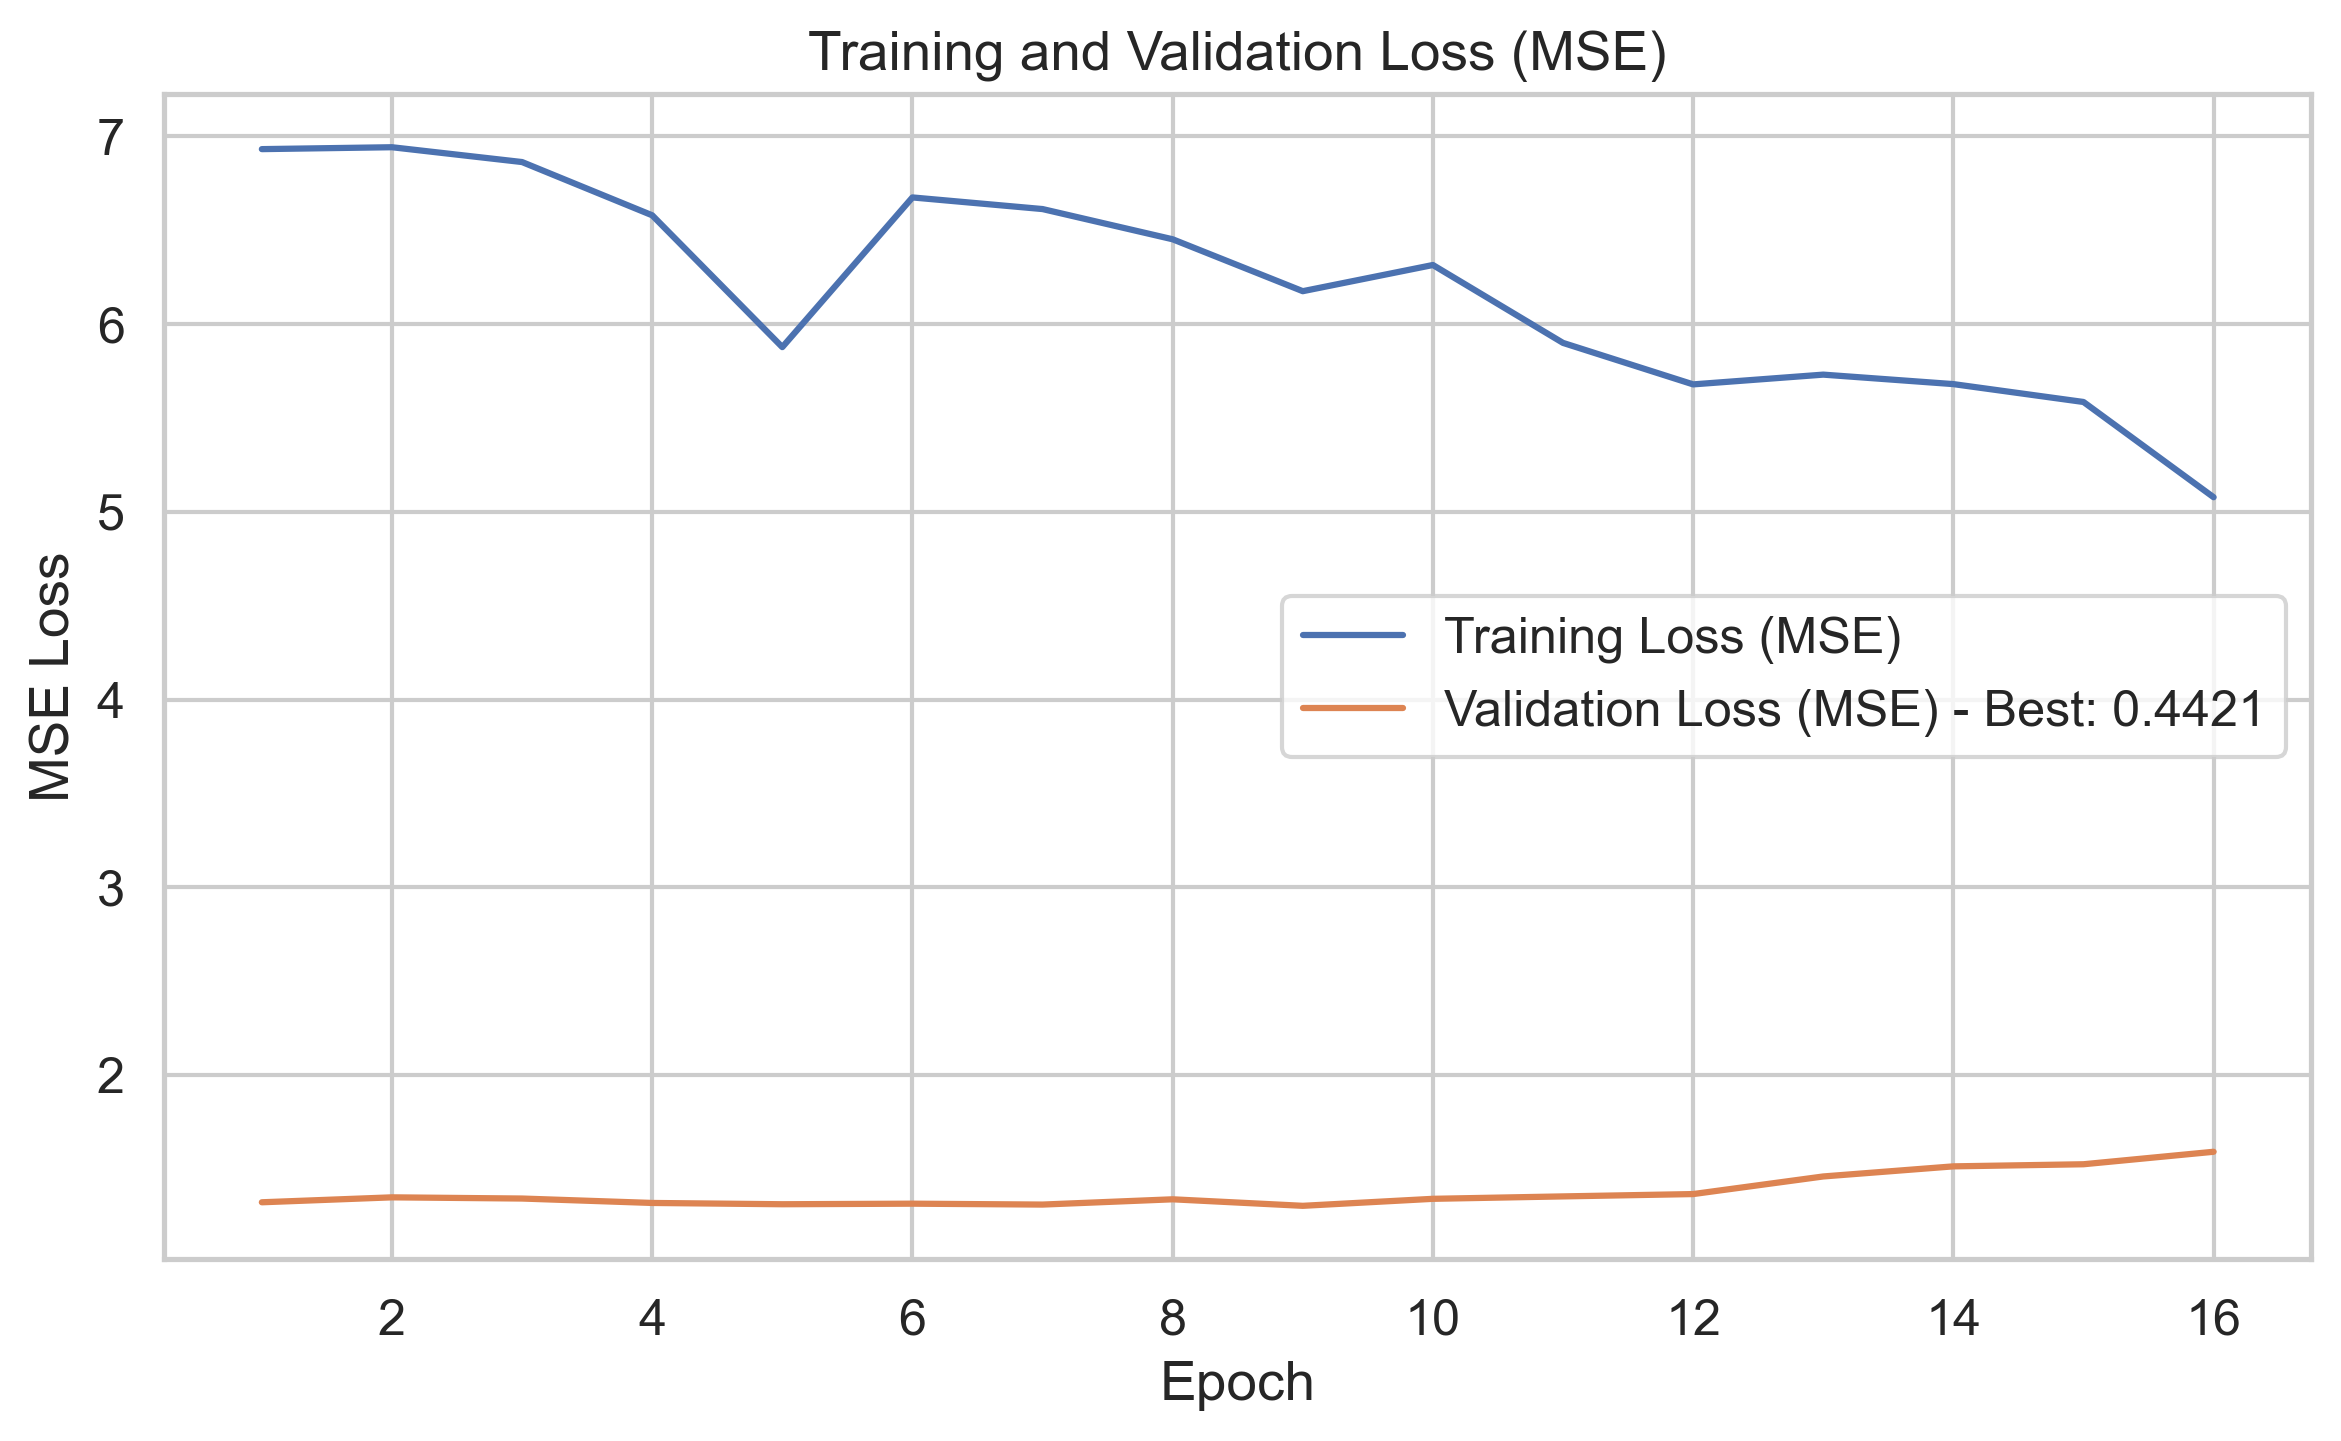

Loss plot saved to: D:\FJTCM\DeepLife\DLProject\lifespan_regression_results_notebook\training_validation_loss.png


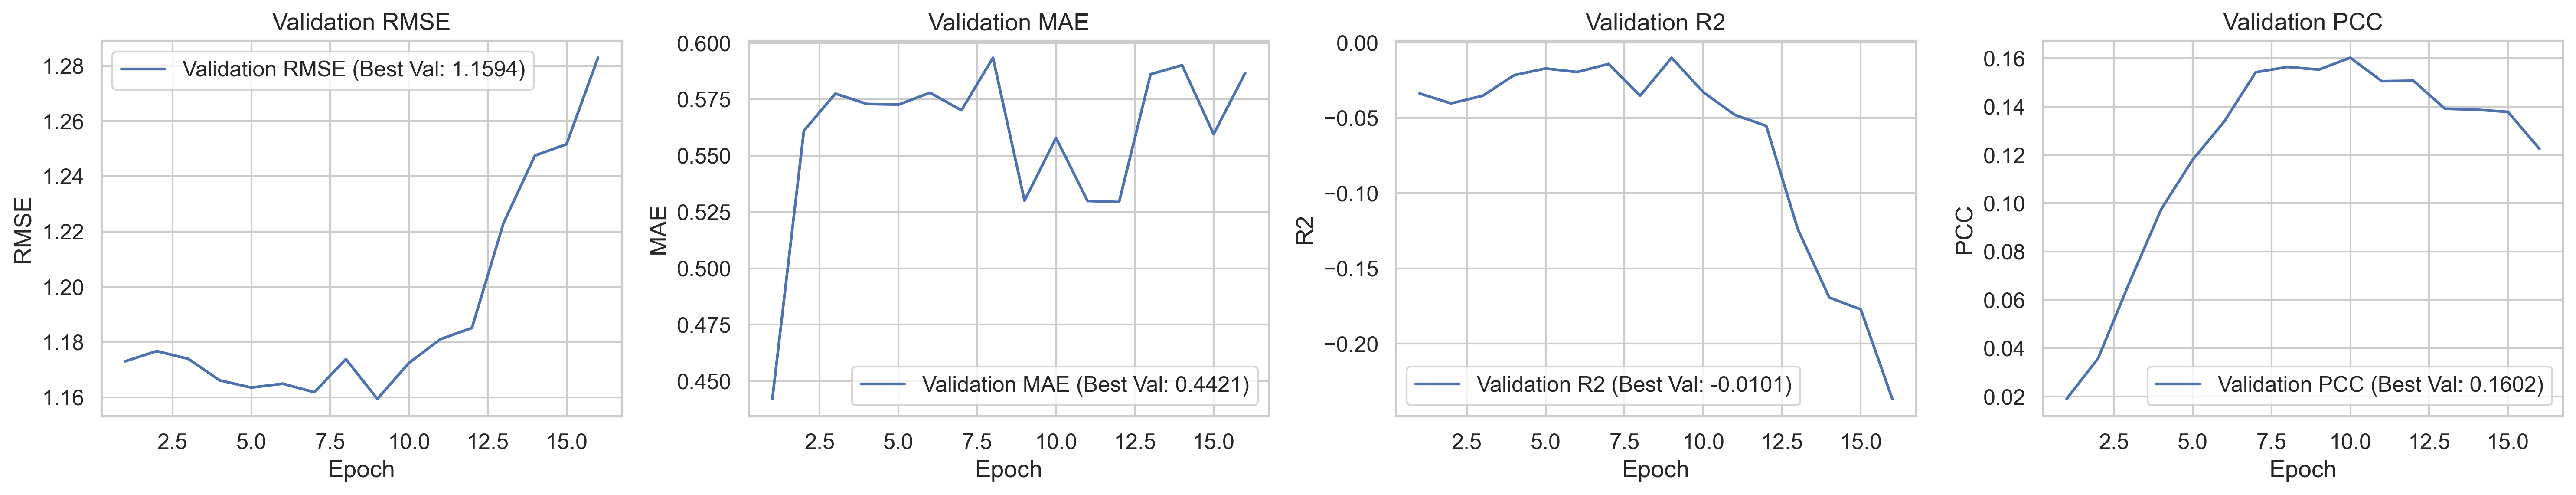

Other validation metrics plot saved to: D:\FJTCM\DeepLife\DLProject\lifespan_regression_results_notebook\validation_metrics_history.png
DEBUG: Reshaping fp_hashed from torch.Size([131072]) to (32, 4096)
DEBUG: Reshaping fp_non_hashed from torch.Size([5312]) to (32, 166)
DEBUG: Reshaping fp_hashed from torch.Size([131072]) to (32, 4096)
DEBUG: Reshaping fp_non_hashed from torch.Size([5312]) to (32, 166)
DEBUG: Reshaping fp_hashed from torch.Size([131072]) to (32, 4096)
DEBUG: Reshaping fp_non_hashed from torch.Size([5312]) to (32, 166)
DEBUG: Reshaping fp_hashed from torch.Size([131072]) to (32, 4096)
DEBUG: Reshaping fp_non_hashed from torch.Size([5312]) to (32, 166)
DEBUG: Reshaping fp_hashed from torch.Size([131072]) to (32, 4096)
DEBUG: Reshaping fp_non_hashed from torch.Size([5312]) to (32, 166)
DEBUG: Reshaping fp_hashed from torch.Size([131072]) to (32, 4096)
DEBUG: Reshaping fp_non_hashed from torch.Size([5312]) to (32, 166)
DEBUG: Reshaping fp_hashed from torch.Size([131072]) t

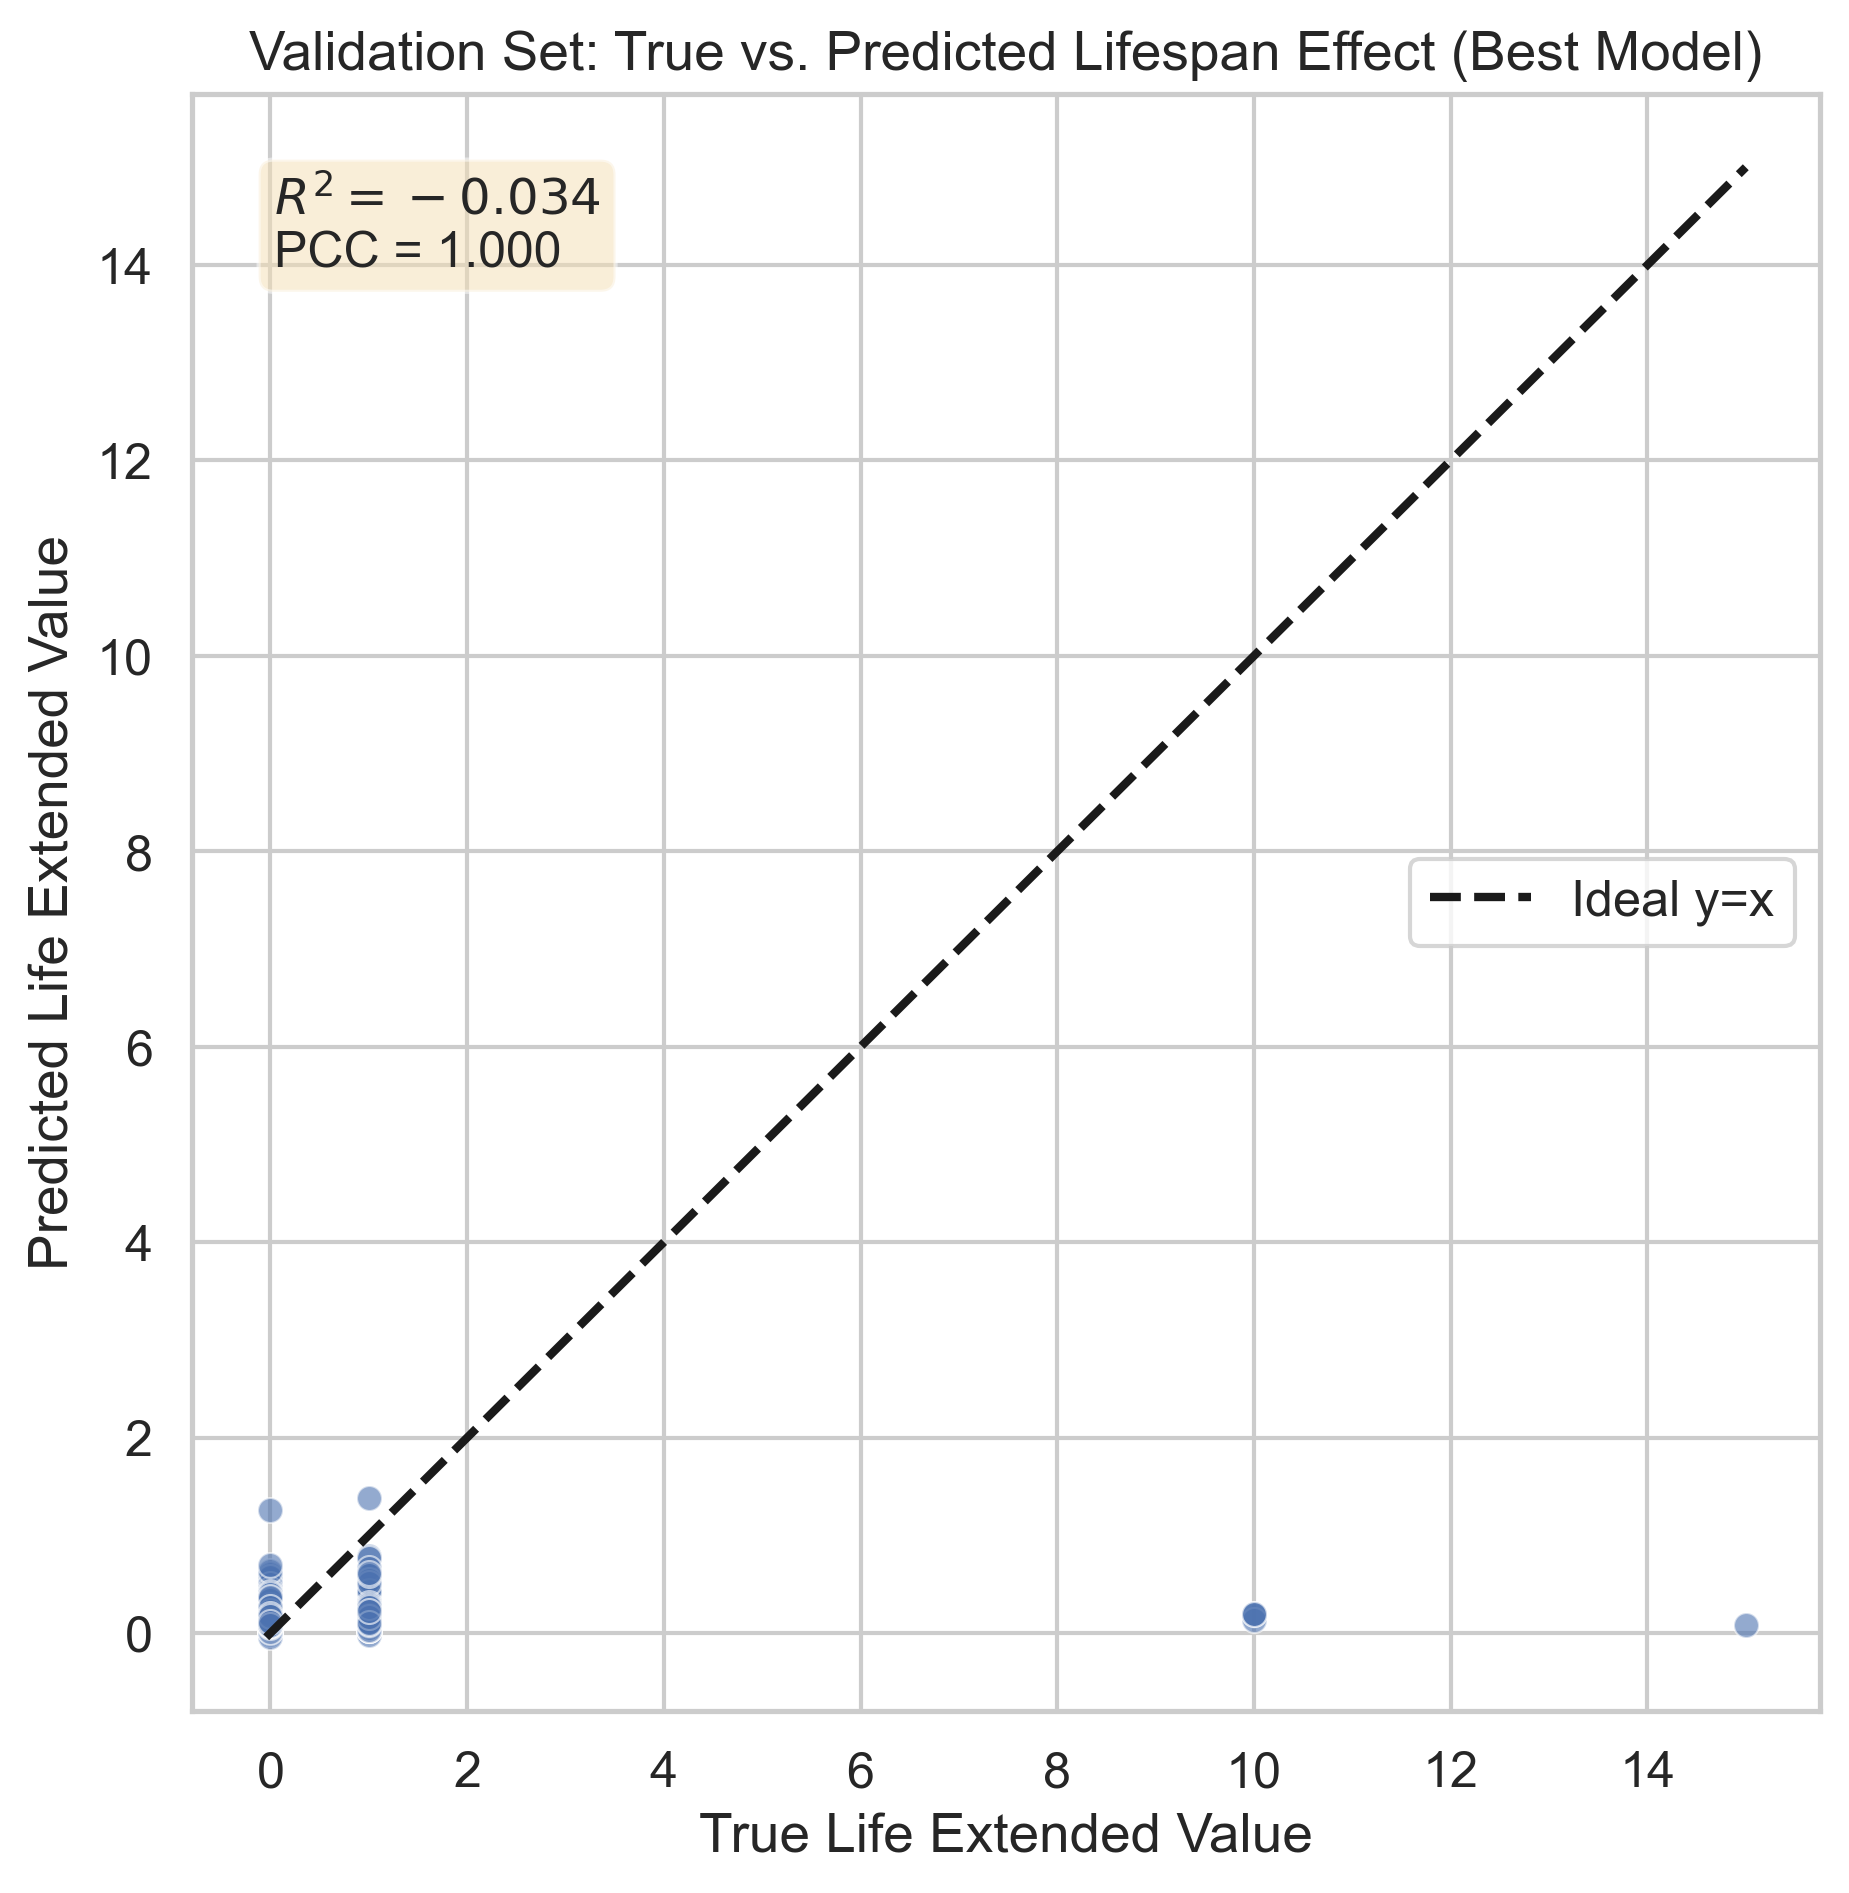

True vs. Predicted scatter plot (validation) saved to: D:\FJTCM\DeepLife\DLProject\lifespan_regression_results_notebook\validation_true_vs_predicted.png


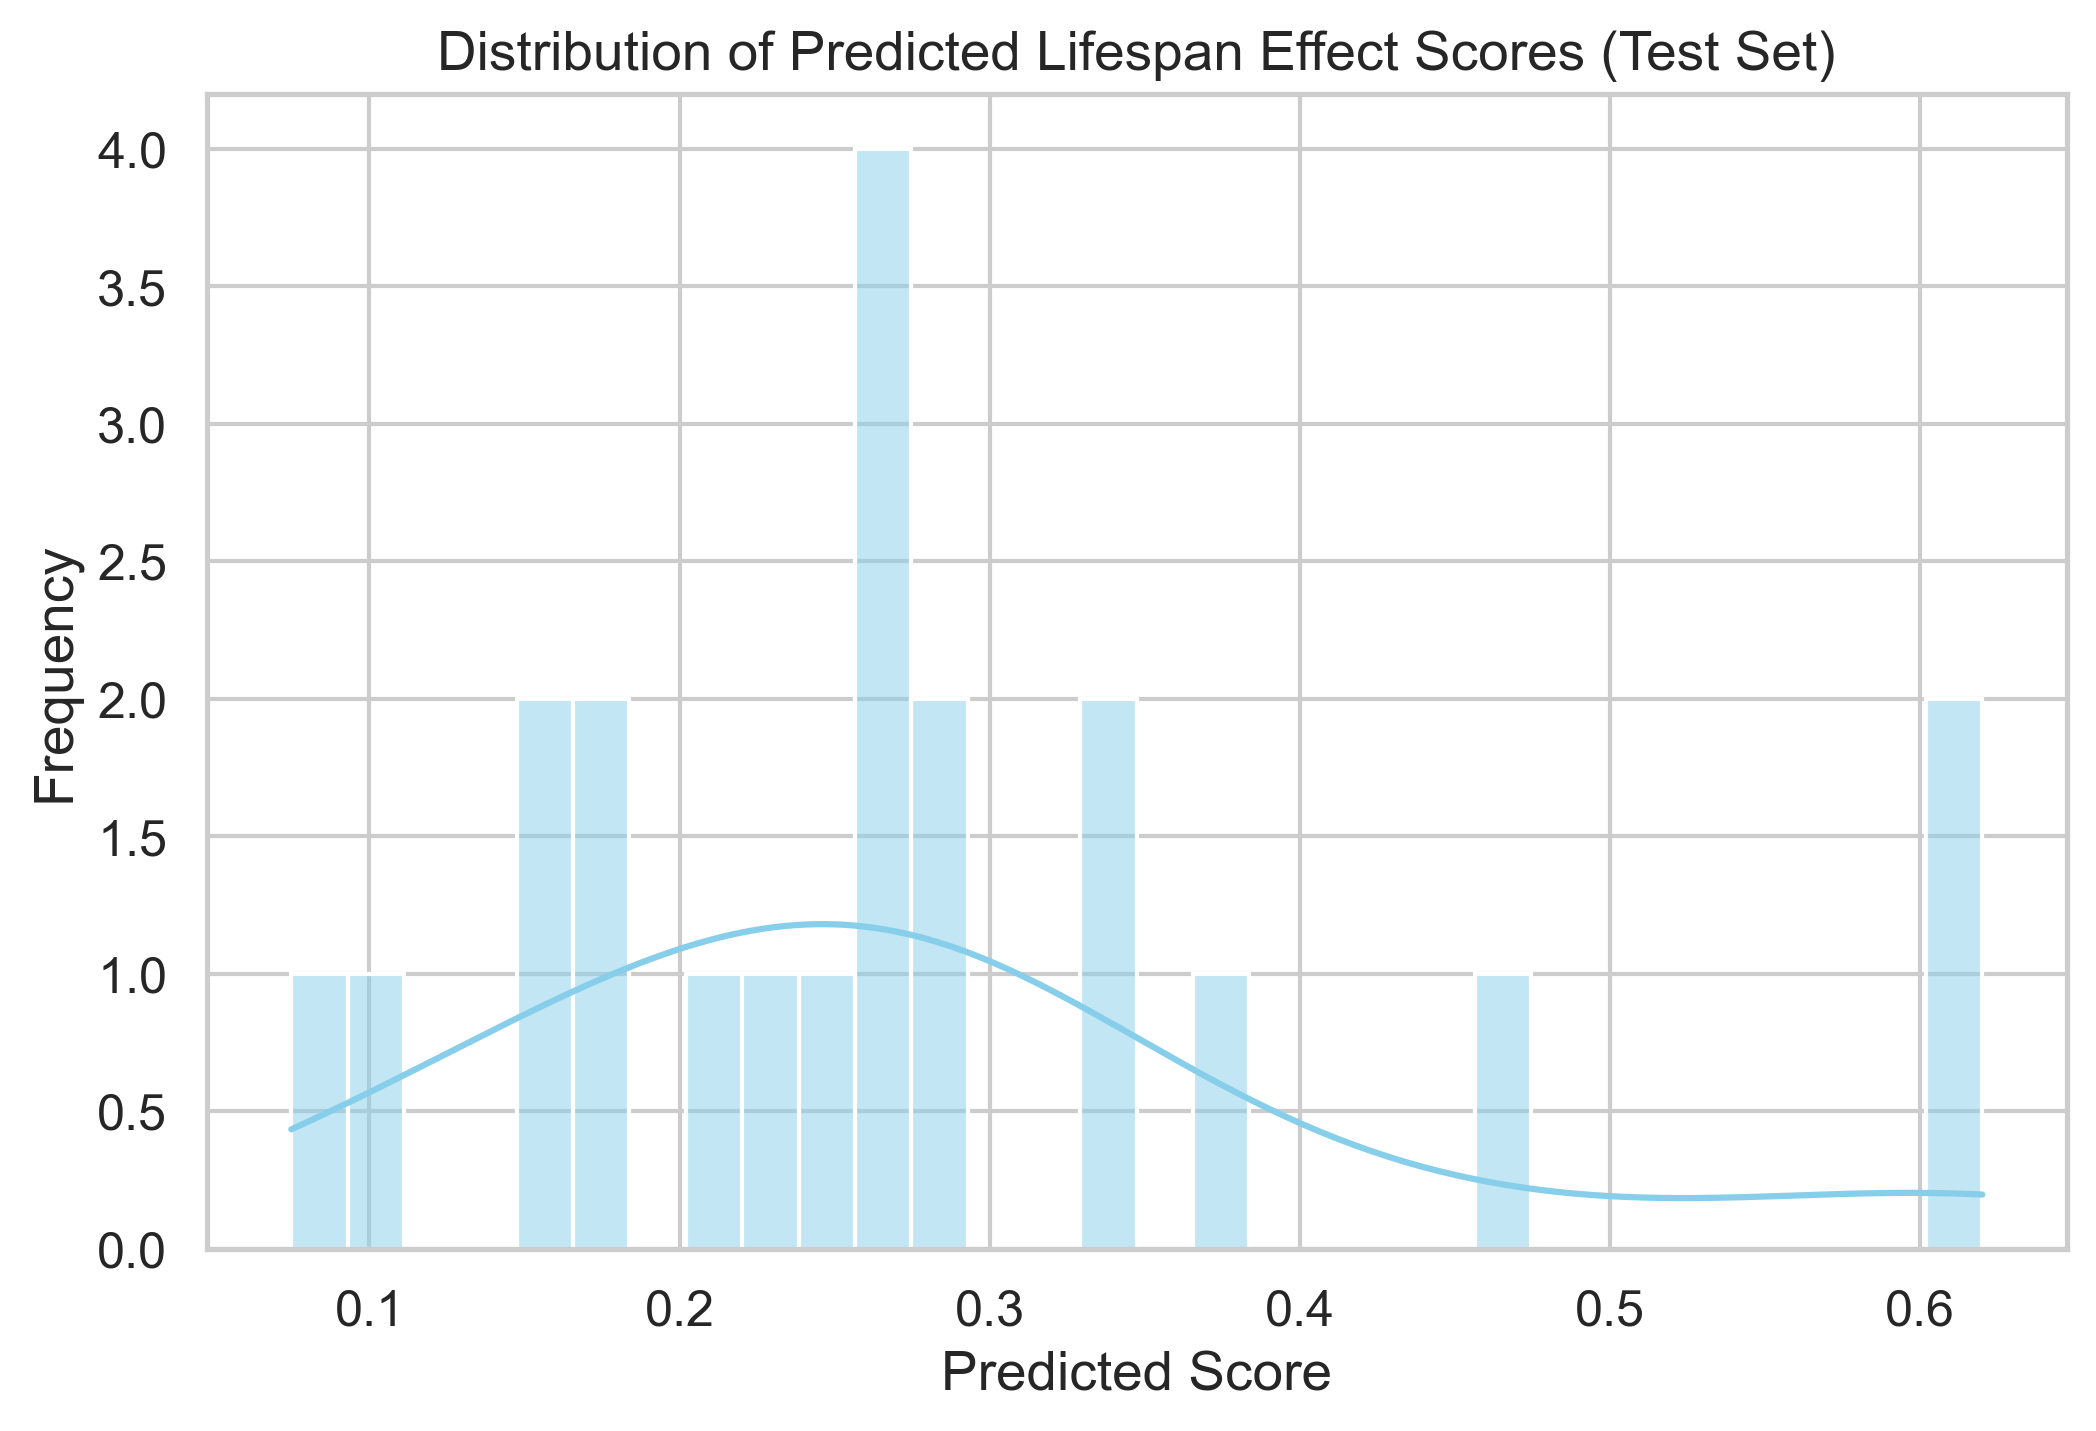

Test score distribution plot saved to: D:\FJTCM\DeepLife\DLProject\lifespan_regression_results_notebook\test_score_distribution.png

--- End of Notebook ---


In [28]:
history_df = pd.DataFrame(training_history)

# --- Plot Training History (Loss) ---
plt.figure(figsize=(8, 5))
plt.plot(history_df['epoch'], history_df['train_loss'], label='Training Loss (MSE)')
plt.plot(history_df['epoch'], history_df['val_loss'], label=f'Validation Loss (MSE) - Best: {early_stopper_reg.val_metric_best:.4f}')
plt.title('Training and Validation Loss (MSE)')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
loss_plot_path = os.path.join(CONFIG["results_dir"], "training_validation_loss.png")
plt.savefig(loss_plot_path, dpi=300)
plt.show()
print(f"Loss plot saved to: {loss_plot_path}")


# --- Plot Other Validation Metrics ---
num_metrics_to_plot = len(metrics_eval_dict)
if num_metrics_to_plot > 1: # If there are metrics other than loss
    plt.figure(figsize=(5 * num_metrics_to_plot, 4))
    plot_idx = 1
    for metric_name in metrics_eval_dict.keys():
        if metric_name == CONFIG['main_metric_name']: # Already part of early stopper info
            best_val_for_metric = early_stopper_reg.val_metric_best if early_stopper_reg.mode == 'min' else early_stopper_reg.val_metric_best
            label_suffix = f' (Best Val: {best_val_for_metric:.4f})'
        else:
            # Find best value for other metrics from history
            metric_values = history_df[f"val_{metric_name}"]
            best_val_for_metric = metric_values.min() if metrics_eval_dict[metric_name].name in ['RMSE', 'MAE'] else metric_values.max()
            label_suffix = f' (Best Val: {best_val_for_metric:.4f})'

        plt.subplot(1, num_metrics_to_plot, plot_idx)
        plt.plot(history_df['epoch'], history_df[f"val_{metric_name}"], label=f'Validation {metric_name}{label_suffix}')
        plt.title(f'Validation {metric_name}')
        plt.xlabel('Epoch')
        plt.ylabel(metric_name)
        plt.legend(loc='best')
        plt.grid(True)
        plot_idx += 1
    plt.tight_layout()
    metrics_plot_path = os.path.join(CONFIG["results_dir"], "validation_metrics_history.png")
    plt.savefig(metrics_plot_path, dpi=300)
    plt.show()
    print(f"Other validation metrics plot saved to: {metrics_plot_path}")


# --- Scatter Plot: True vs. Predicted Values for Validation Set ---
# Get final validation set predictions from the best model
_, val_true_final, val_pred_final = training_wrapper.evaluate(val_loader) # training_wrapper uses the loaded best model

plt.figure(figsize=(7, 7))
plt.scatter(val_true_final, val_pred_final, alpha=0.6, edgecolors='w', linewidth=0.5)
# Add a line y=x for reference
min_val = min(val_true_final.min(), val_pred_final.min())
max_val = max(val_true_final.max(), val_pred_final.max())
plt.plot([min_val, max_val], [min_val, max_val], 'k--', lw=2, label="Ideal y=x")
plt.title(f'Validation Set: True vs. Predicted Lifespan Effect (Best Model)')
plt.xlabel('True Life Extended Value')
plt.ylabel('Predicted Life Extended Value')
plt.legend()
plt.grid(True)
# Add R2 and PCC to the plot
r2_val = r2_score(val_true_final, val_pred_final)
pcc_val, _ = np.corrcoef(val_true_final.flatten(), val_pred_final.flatten())[0] if len(val_true_final)>1 else (np.nan, np.nan) # Pearson from numpy for arrays
plt.text(0.05, 0.95, f'$R^2 = {r2_val:.3f}$\nPCC = {pcc_val:.3f}', transform=plt.gca().transAxes,
         fontsize=12, verticalalignment='top', bbox=dict(boxstyle='round,pad=0.3', fc='wheat', alpha=0.5))
scatter_plot_path = os.path.join(CONFIG["results_dir"], "validation_true_vs_predicted.png")
plt.savefig(scatter_plot_path, dpi=300)
plt.show()
print(f"True vs. Predicted scatter plot (validation) saved to: {scatter_plot_path}")


# --- Distribution of Predicted Scores on Test Set ---
plt.figure(figsize=(8, 5))
sns.histplot(results_output_df['Predicted_Lifespan_Effect'], kde=True, bins=30, color='skyblue')
plt.title('Distribution of Predicted Lifespan Effect Scores (Test Set)')
plt.xlabel('Predicted Score')
plt.ylabel('Frequency')
plt.grid(True)
test_score_dist_path = os.path.join(CONFIG["results_dir"], "test_score_distribution.png")
plt.savefig(test_score_dist_path, dpi=300)
plt.show()
print(f"Test score distribution plot saved to: {test_score_dist_path}")

print("\n--- End of Notebook ---")


In [15]:
import datetime
import os

# 你的原始 notebook 文件名
notebook_file = "LifespanPredict.ipynb"

# 获取当前时间并格式化为字符串 (年-月-日_时-分-秒)
timestamp = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

# 构建输出文件名 (不含 .html 后缀，nbconvert 会自动添加)
# 例如：npclassifier_2023-10-27_10-30-55
output_filename_base = f"{os.path.splitext(notebook_file)[0]}_{timestamp}"

# 构建完整的 nbconvert 命令
# --output <basename>  nbconvert 会自动添加 .html 后缀
nbconvert_command = f"jupyter nbconvert --to html --output {output_filename_base} {notebook_file}"

print(f"将要执行的命令: {nbconvert_command}")

# 在 Jupyter Notebook 代码单元格中执行
!{nbconvert_command}

print(f"\n检查输出文件: {output_filename_base}.html")


将要执行的命令: jupyter nbconvert --to html --output LifespanPredict_2025-06-23_20-38-48 LifespanPredict.ipynb

检查输出文件: LifespanPredict_2025-06-23_20-38-48.html


[NbConvertApp] Converting notebook LifespanPredict.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 4 image(s).
[NbConvertApp] Writing 1507529 bytes to LifespanPredict_2025-06-23_20-38-48.html
